Optimal Number of Clusters: 2
Best DB Index: 1.36


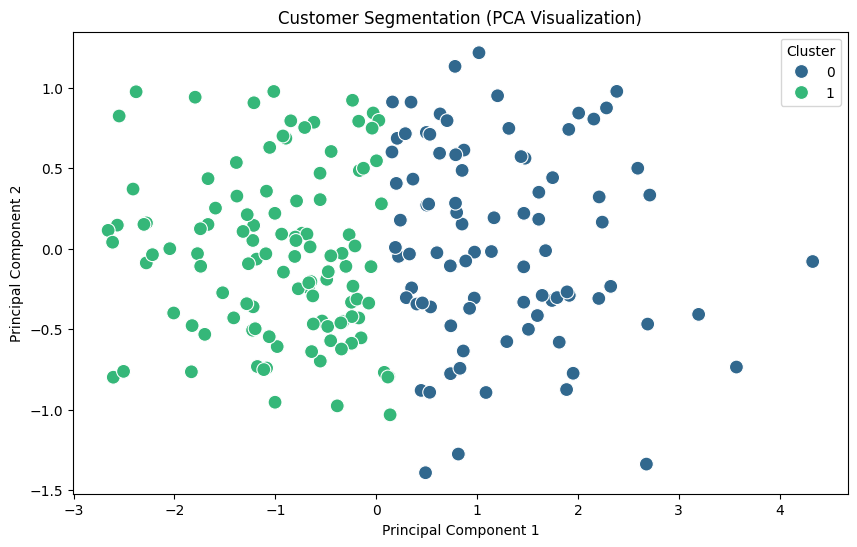

Clustering results saved to 'FirstName_LastName_Clustering.csv'


In [2]:
# Import necessary libraries
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Step 1: Load and merge datasets
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")

# Merge datasets
merged = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')

# Aggregate transaction data for each customer
customer_summary = merged.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'TransactionID': 'count',
    'Category': lambda x: x.mode()[0],  # Most frequent category
    'Region': 'first'  # Region from customers.csv
}).reset_index()

# Rename columns for clarity
customer_summary.rename(columns={
    'TotalValue': 'TotalSpending',
    'TransactionID': 'NumTransactions',
    'Category': 'PreferredCategory'
}, inplace=True)

# Step 2: Prepare the data
# Encode categorical features
encoder = OneHotEncoder()
encoded_region = encoder.fit_transform(customer_summary[['Region']]).toarray()
encoded_category = encoder.fit_transform(customer_summary[['PreferredCategory']]).toarray()

# Standardize numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_summary[['TotalSpending', 'NumTransactions']])

# Combine all features into a single array
final_features = np.hstack((scaled_features, encoded_region, encoded_category))

# Step 3: Apply Clustering (K-Means)
best_k = None
best_db_index = float('inf')
db_index_scores = []

for k in range(2, 11):  # Trying cluster sizes from 2 to 10
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(final_features)
    db_index = davies_bouldin_score(final_features, clusters)
    db_index_scores.append(db_index)
    if db_index < best_db_index:
        best_db_index = db_index
        best_k = k
        best_model = kmeans

print(f"Optimal Number of Clusters: {best_k}")
print(f"Best DB Index: {best_db_index:.2f}")

# Assign cluster labels to the customers
customer_summary['Cluster'] = best_model.labels_

# Step 4: Visualize the clusters
# For visualization, use PCA to reduce dimensions to 2D
pca = PCA(n_components=2)
pca_features = pca.fit_transform(final_features)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=customer_summary['Cluster'], palette='viridis', s=100)
plt.title('Customer Segmentation (PCA Visualization)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

# Step 5: Export the clustering results
customer_summary.to_csv('FirstName_LastName_Clustering.csv', index=False)
print("Clustering results saved to 'FirstName_LastName_Clustering.csv'")
